A notebook to try to remove noise from patents before OCR'ing them. Information extraction proved to be very challenging without this initial preprocessing. Multiple attempts are made to remove noise in this notebook.

In [86]:
from scipy import ndimage, misc
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import words
from nltk.metrics.distance import (
    edit_distance,
    jaccard_distance,
    )
from nltk.util import ngrams
nltk.download('words')
import pandas
from PIL import Image
import numpy as np
import pytesseract
from autocorrect import Speller
import neuralcoref
spell = Speller()
import spacy
from spacy import displacy
from collections import Counter
from patent_classification_utils import classify_page, classify_patent, extract_imgs, extract_text, page_has_drawing, extract_text_pages
from detectron2.data.detection_utils import read_image
from ocrutils import OCR_Pages
import os
nlp = spacy.load("en_core_web_lg")
path_to_patents = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded'
from skimage.feature import canny
from skimage.morphology import dilation, erosion
import cv2
import matplotlib.pyplot as plt


[nltk_data] Downloading package words to
[nltk_data]     /Users/andrealphonse/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [87]:
# Trying out on example
# FIG_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/430/00000001.tif'
# TEXT_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/430/00000002.tif'
# FIG_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/604/00000001.tif'
# TEXT_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/1645/00000002.tif'#'/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/604/00000002.tif'
# fig_im = Image.open(FIG_PATH)
# text_im = Image.open(TEXT_PATH)
# fig_array = np.array(fig_im)
# text_array = np.array(text_im)

In [99]:
def get_tif_paths(path):
    """
    function to get paths to all tifs in a given folder
    Args:
    path - path to folder
    Returns:
    tifs - a list of the paths to the tifs
    """
    tifs = []
    for path, dirs, files in os.walk(path):
        for f in files:
            if f.endswith('tif'):
                tifs.append('{}/{}'.format(path, f))
    return tifs

def OCR_img(img):
    """
    function to perform OCR on a given image
    Args:
    img - the image to OCR
    Return:
    str_from_img - a string of the recognized text in the image
    """
    str_from_img = pytesseract.image_to_string(img,config='--psm 6')
    return str_from_img

def get_tifs(patent_nb,path_to_patents='/Volumes/Non-Backup_Files/US-patents/random_sample_seeded'):
    """
    function to get the a list of the tifs of a given US patent, the default path only includes the random sample used for the project
    Args:
    patent_nb - the patent number
    path_to_patents - the path to the patents
    Returns:
    tif_imgs - list of of tif images in BGR format (detectron2 BGR)
    """
    tifs = get_tif_paths("{}/{}/".format(path_to_patents, patent_nb))
    tif_imgs = [read_image(tif, format="BGR") for tif in tifs]
    return tif_imgs
    
def get_cv2_pages(patent_nb,path_to_patents='/Volumes/Non-Backup_Files/US-patents/random_sample_seeded'):                
    """
    function to get the a list of the tifs of a given US patent in cv2 format, the default path only includes the random sample used for the project
    Args:
    patent_nb - the patent number
    path_to_patents - the path to the patents
    Returns:
    tif_imgs - list of of tif images in cv2 format
    """
    tifs = get_tif_paths("{}/{}/".format(path_to_patents, patent_nb))
    tif_imgs = [cv2.imread(tif, 0) for tif in tifs]
    return tif_imgs
    
def ocr(patent_nb,path_to_patents='/Volumes/Non-Backup_Files/US-patents/random_sample_seeded'):              
    """
    function to OCR a whole patent, the default path only includes the random sample used for the project
    Args:
    patent_nb - the patent number
    path_to_patents - the path to the patents
    Returns:
    a string of the recognized text in the patent
    """
    #fetch all paths to tif's                  
    tif_imgs = get_tifs(patent_nb,path_to_patents)                                   
    text_indices = []
    for i in range(len(tif_imgs)):
        if not page_has_drawing(tif_imgs[i]):
            text_indices.append(i)
    return OCR_Pages([ndimage.median_filter(np.array(Image.open(tifs[i])), size=4) for i in text_indices])

In [100]:
#taking an example patent: number 1645
tifs = get_tifs(1645)
# tifs = get_tifs(38529)
text_pages, text_indices = extract_text_pages(tifs)

In [42]:
#the baseline for the OCR, improvements compared against this
print(OCR_Pages(text_pages))

~Unitep StratTes PATENT OFFICE.

SETH LAMB, OF NEW YORK, N. Y.

IMPROVEMENT IN MOWING-MACHINES.

 

Specification forming part of Letters Patent No. 1,645, dated June 20, 1840,

To all whom tt may concern:

Be it known that I,SerH Lams, of the city,
county,and State of New York, have invented,
constructed, and applied to use a new and use-

‘ful Improvement in the Machinery for Cutting

Gro sd4ndGrain; andI do hereby declare that
the rollowing is a fall and exact description
thereof, with reference to the accompanying
drawings, making part of this specification,
and in which the same parts are designated
by the same letters of reference in all the dif-
ferent figures.

Figure 1 represents a vertical projection of
the geared side of the machine; Fig. 2, a top
view, witha part of the floor or casing removed
to exhibit the sickle-wheel, gearing, and pal-
leys and to exhibit their connection and posi-
tion with the frame of the machine; Fig. 3, a
front vertical projection. Tig. 4 is a pers

### Median Filter Attempt

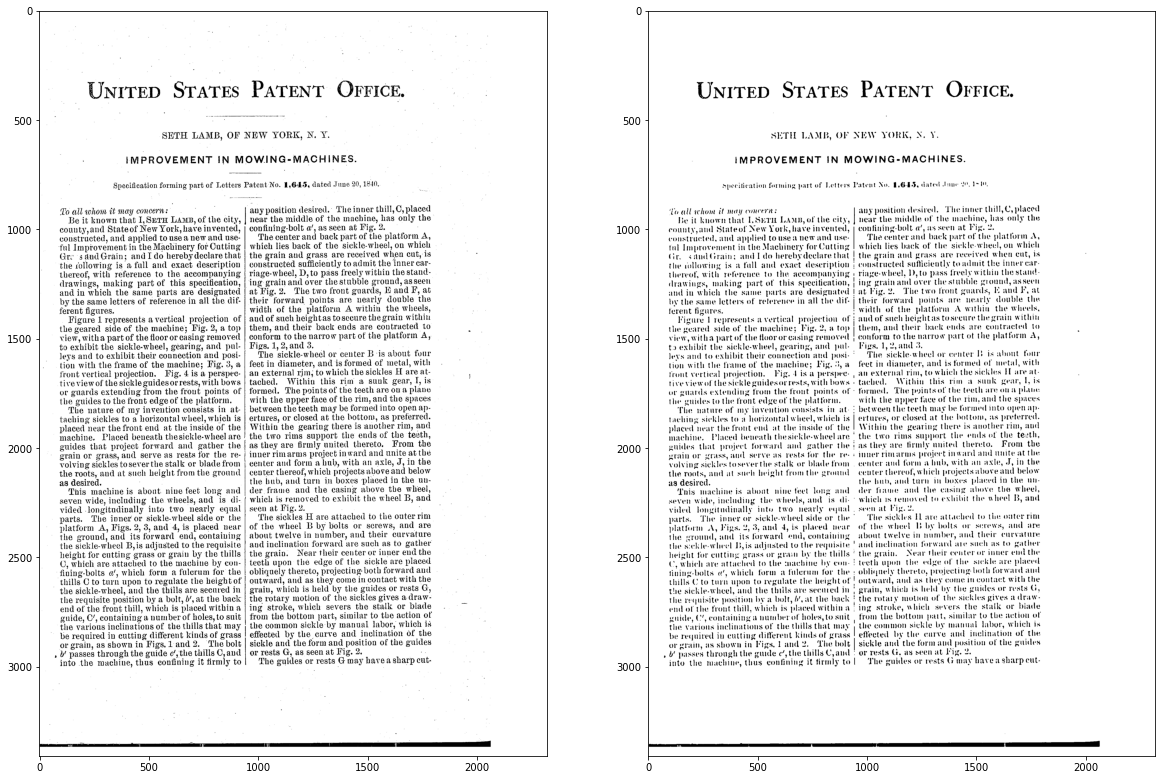

In [44]:
fig = plt.figure(figsize=(20, 20))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
# eg = text_array#misc.ascent()
result = ndimage.median_filter(text_pages[0], size=5)
ax1.imshow(text_pages[0])
ax2.imshow(result)
plt.show()

In [45]:
print(OCR_img(result))

Unrrep STATES PATENT OFFICE.

SETH LAMB, OF NEW YORK, N.Y.

IMPROVEMENT IN MOWING-MACHINES.

specification forming part of Letters Patent No. 1,645, dated Jane 28. 1-10,

To allachom it may concern:

Be it known that [Seria Lams, of the city,
county,and Stateof New York, have invented,
constructed, and applied to use a new and use-
ful Improvement in the Machinery for Catting
Gr. sand Grain; and I do hereby declare that
the vollowing is a fall and exact description
thereof, with reference to the accompanying
drawings, making part of this specification,
and in which the same parts are designated
by the same letters of reterence in all the dif-
ferent figures.

Figure 1 represents a vertical projection of

the geared side of the machine; Fig. 2, a top
view, witha part of the floor or casing removed
to exhibit the sickle-wheel, gearing, and pal-

any position desired. ‘The inner thill, C, placed
neat the middle of the machine, has only the
confining-bolt a4, as scen at Fig. 2.

The center

We can notice a slight improvement. The lines are at least well recognized (e.g. it manages to dictinguish two columns). However, the way it distinguishes both columns is highly irregular and causes major errors such as the one near the end of the document where it processes the end of the left column as independent of said column.

### Gaussian Filter Attempt

In [47]:
# TEXT_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/430/00000002.tif'
# img = cv2.imread(TEXT_PATH,0)
cv2_text_pages = [get_cv2_pages(1645)[i] for i in text_indices]

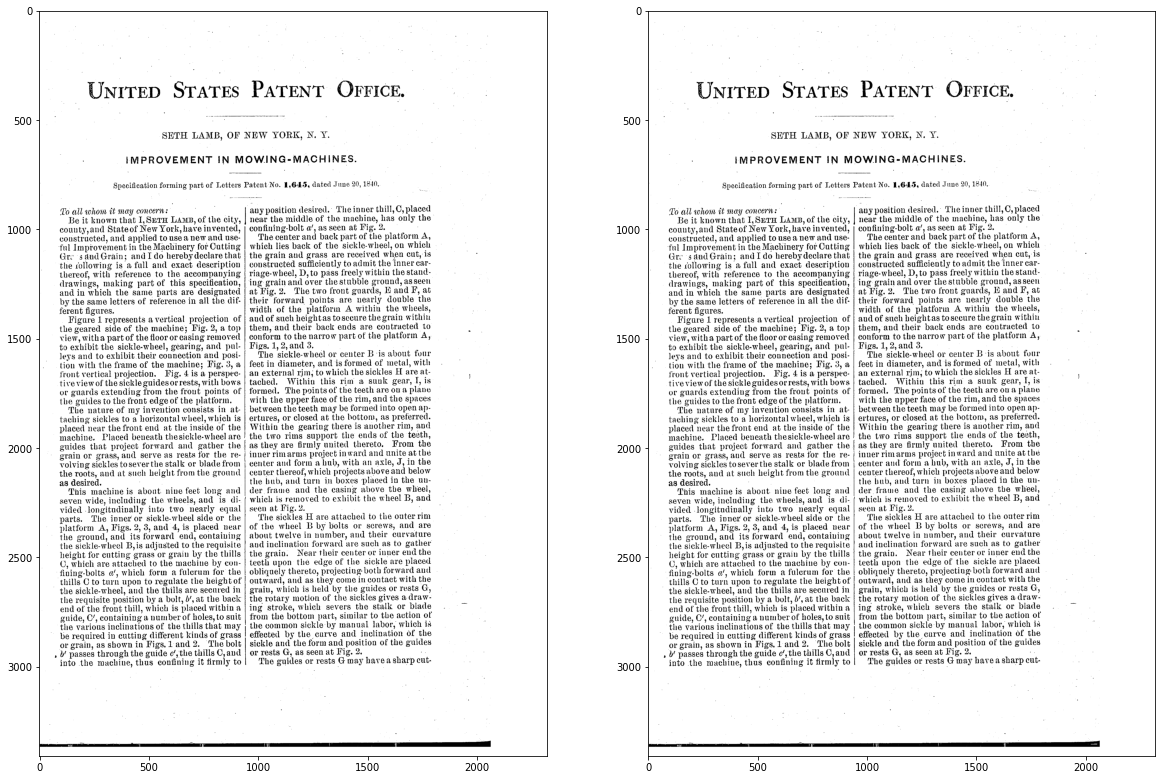

In [48]:
fig = plt.figure(figsize=(20, 20))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
# ascent = text_array#misc.ascent()
# result = canny(text_array, sigma=2.5)
# result = np.logical_not(erosion(dilation(canny(text_array, sigma=1))))
# result = cv2.threshold(text_pages[0],127,255,cv2.THRESH_TOZERO)
result = cv2.adaptiveThreshold(cv2_text_pages[0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,25,1)
ax1.imshow(cv2_text_pages[0])
ax2.imshow(result)
plt.show()

In [49]:
print(OCR_img(result))

~Unitep StratTes PATENT OFFICE.

SETH LAMB, OF NEW YORK, N. Y.

IMPROVEMENT IN MOWING-MACHINES.

 

Specification forming part of Letters Patent No. 1,645, dated June 20, 1840,

To all whom tt may concern:

Be it known that I,SerH Lams, of the city,
county,and State of New York, have invented,
constructed, and applied to use a new and use-

‘ful Improvement in the Machinery for Cutting

Gro sd4ndGrain; andI do hereby declare that
the rollowing is a fall and exact description
thereof, with reference to the accompanying
drawings, making part of this specification,
and in which the same parts are designated
by the same letters of reference in all the dif-
ferent figures.

Figure 1 represents a vertical projection of
the geared side of the machine; Fig. 2, a top
view, witha part of the floor or casing removed
to exhibit the sickle-wheel, gearing, and pal-
leys and to exhibit their connection and posi-
tion with the frame of the machine; Fig. 3, a
front vertical projection. Tig. 4 is a pers

No significant improvement is noted here.

### Otsu's Method Attempt

In [51]:
from skimage import data
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte

In [52]:
cv2_text_pages[0]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

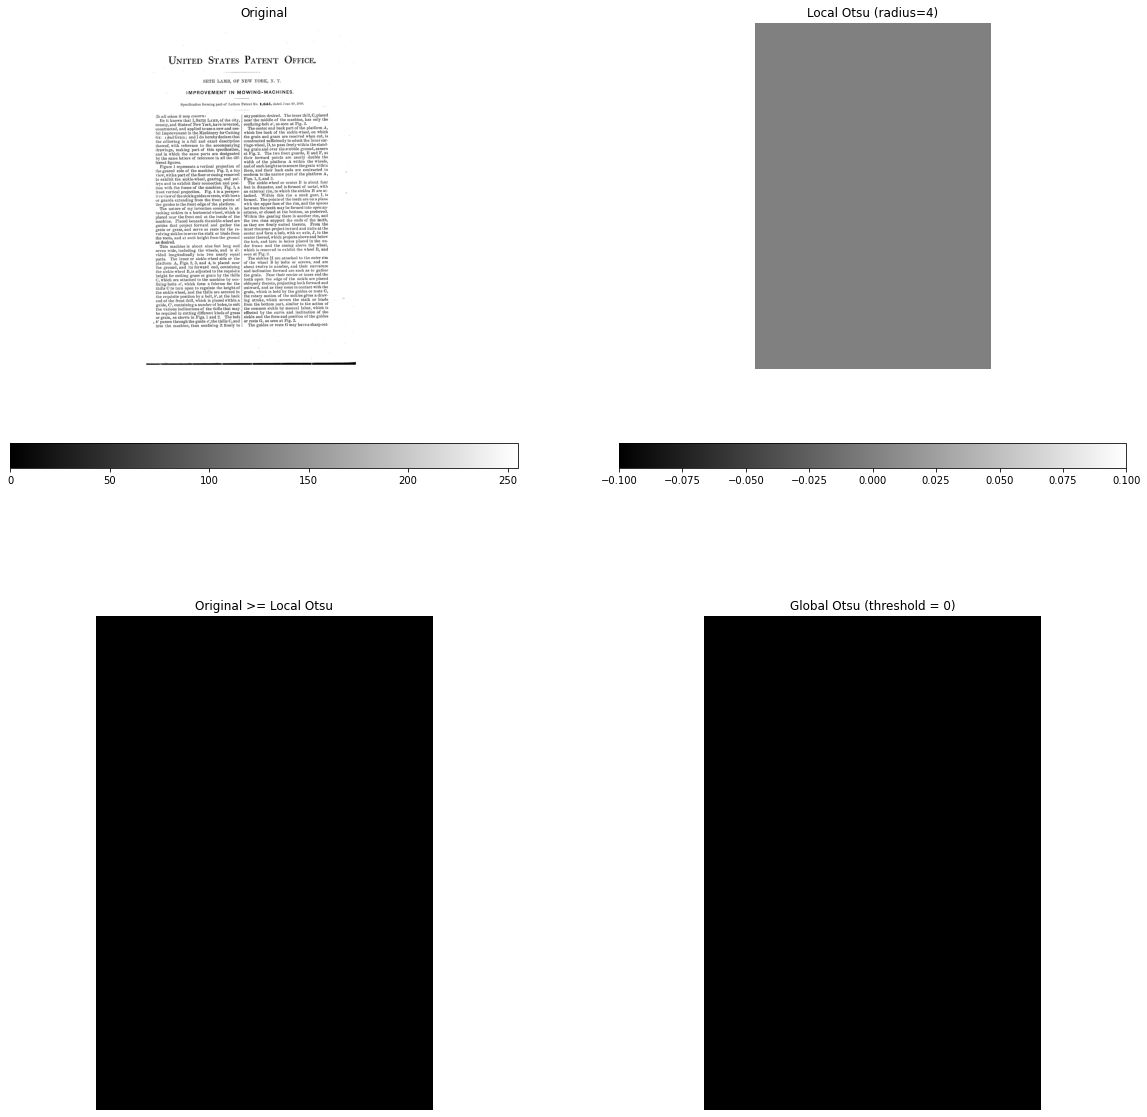

In [53]:
# img = img_as_ubyte(data.page())

radius = 4
selem = disk(radius)

local_otsu = rank.otsu(cv2_text_pages[0], selem)
threshold_global_otsu = threshold_otsu(cv2_text_pages[0])
global_otsu = cv2_text_pages[0] >= threshold_global_otsu


fig, ax = plt.subplots(2, 2, figsize=(20, 20))
ax1, ax2, ax3, ax4 = ax.ravel()

fig.colorbar(ax1.imshow(cv2_text_pages[0], cmap=plt.cm.gray),
           ax=ax1, orientation='horizontal')
ax1.set_title('Original')
ax1.axis('off')

fig.colorbar(ax2.imshow(local_otsu, cmap=plt.cm.gray),
           ax=ax2, orientation='horizontal')
ax2.set_title('Local Otsu (radius=%d)' % radius)
ax2.axis('off')

ax3.imshow(cv2_text_pages[0] >= local_otsu, cmap=plt.cm.gray)
ax3.set_title('Original >= Local Otsu' % threshold_global_otsu)
ax3.axis('off')

ax4.imshow(global_otsu, cmap=plt.cm.gray)
ax4.set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax4.axis('off')

plt.show()

One shortcoming of otsu's method is its lack of support for documents with small objects. This disatdvantage is clearly affecting its performance on the patent documents.

### Equalizer Method

One thing which could help in the OCR process is increasing the contrast in the image. Equalisation is a common method to increase the contrast in a given image.


https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_local_equalize.html

In [55]:
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank


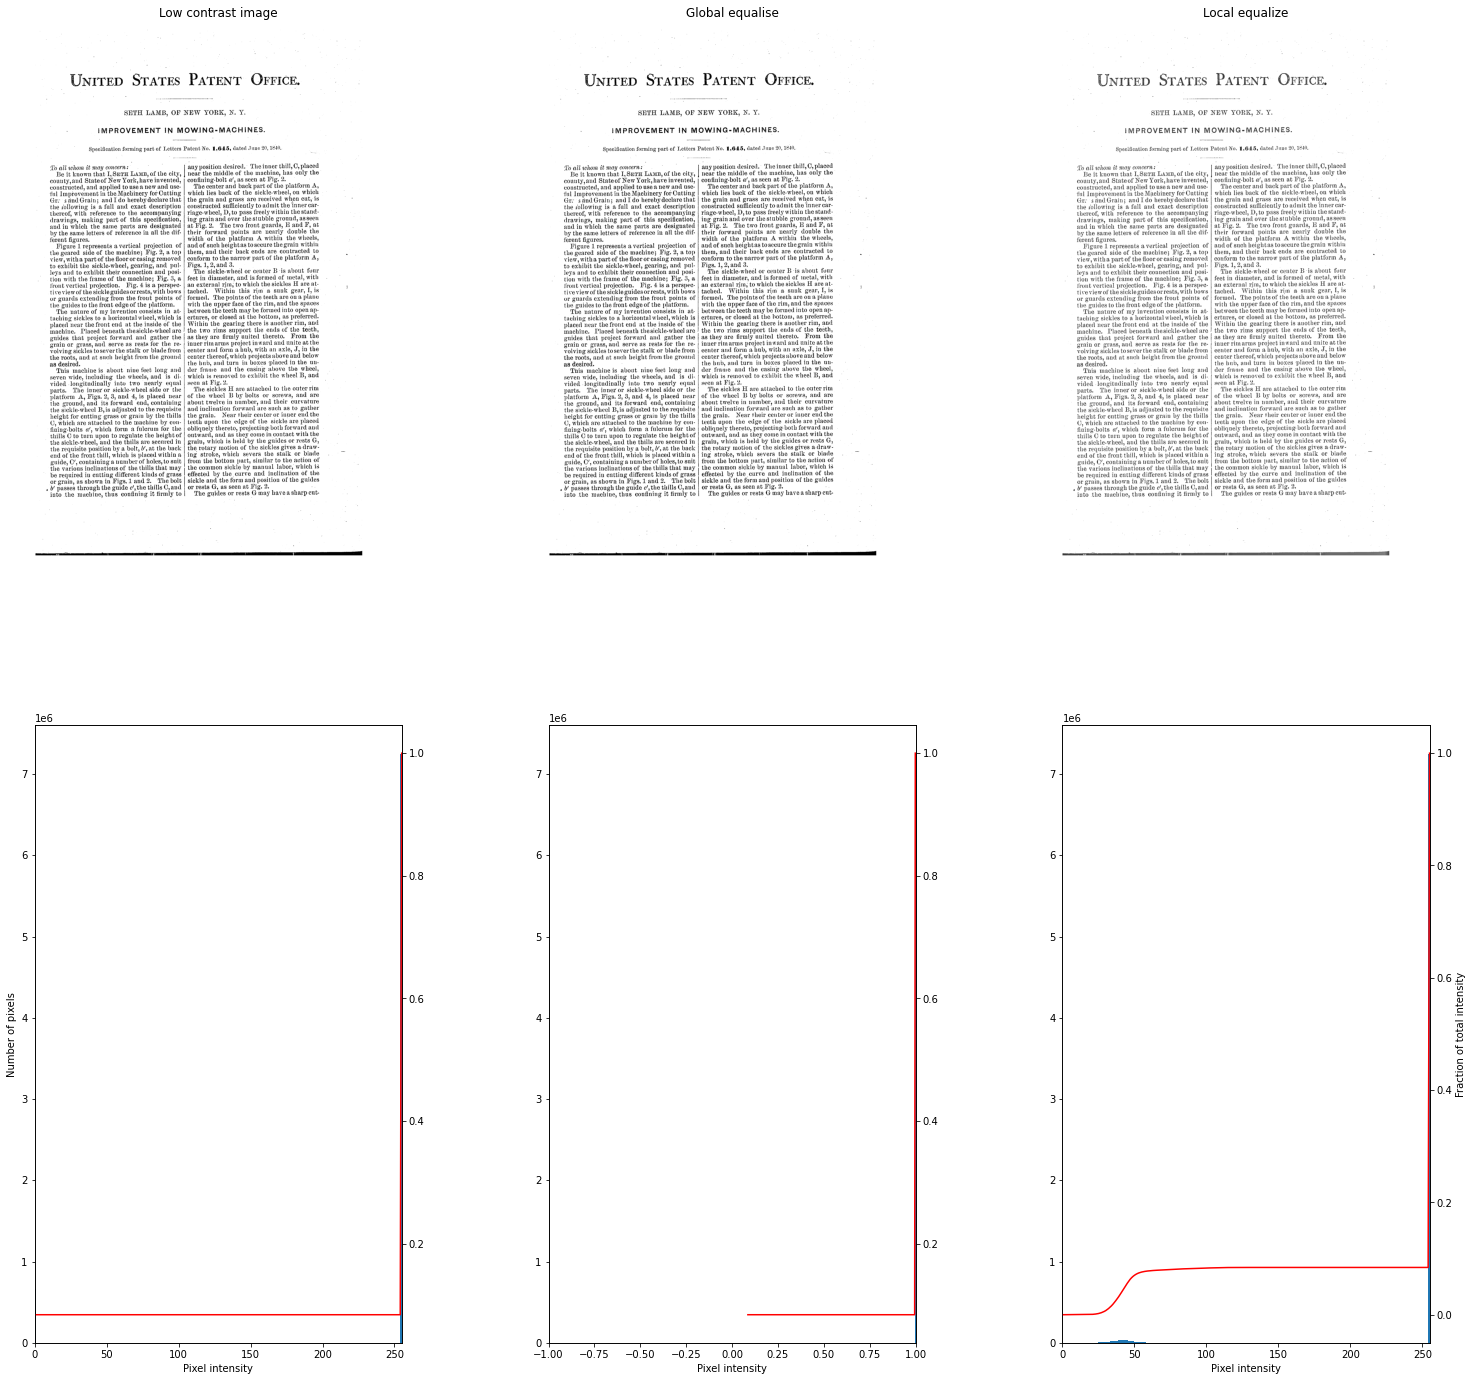

In [56]:
def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[img.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = cv2_text_pages[0]

# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
selem = disk(30)
img_eq = rank.equalize(img, selem=selem)


# Display results
fig, axes = plt.subplots(2, 3, figsize=(25, 25))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.subplots_adjust(wspace=0.4)
plt.show()

In [57]:
img_eq

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [58]:
print(OCR_img(img_eq))

~Unitrep States PATENT QOFFIce.

SETH LAMB, OF NEW YORK, N. Y.

IMPROVEMENT IN MOWING-MACHINES.

 

Specification forming part of Letters Patent No. 1,645, dated June 20, 1840,

To all whom tt may concern:

Be it known that I,SerTH Lamp, of the city,
county,and State of New York, have invented,
constructed, and applied to use a new and use-

‘ful Improvement in the Machinery for Cutting

Gro sand Grain; andI do hereby declare that
the rollowing is a fall and exact description
thereof, with reference to the accompanying
drawings, making part of this specification,
and in which the same parts are designated
by the same letters of reference in all the dif-
ferent figures.

Figure 1 represents a vertical projection of
the geared side of the machine; Fig. 2, a top
view, witha part of the floor or casing removed
to exhibit the sickle-wheel, gearing, and pul-
leys and to exhibit their connection and posi-
tion with the frame of the machine; Fig. 3, a
front vertical projection. Tig. 4 is a per

In [59]:
# increasing contrast

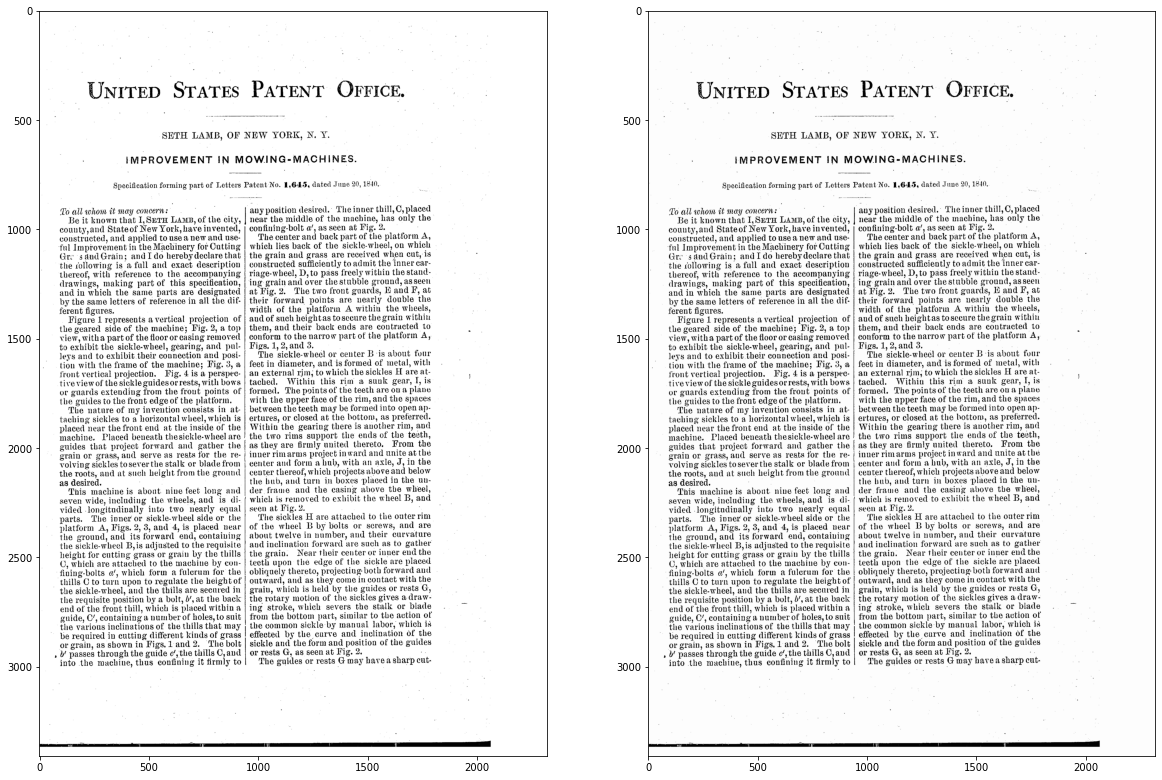

In [63]:
fig = plt.figure(figsize=(20, 20))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
# eg = text_array#misc.ascent()
result = text_pages[0] * 3
ax1.imshow(text_pages[0])
ax2.imshow(result)
plt.show()

In [64]:
print(OCR_img(result))

~Unitrep StraTes PATENT OFFICE.

SETH LAMB, OF NEW YORK, N. Y.

IMPROVEMENT IN MOWING-MACHINES.

 

Specification forming part of Letters Patent No. 1,645, dated June 20, 1840,

To all whom tt may concern:

Be it known that I,SerH Lamp, of the city,
county,and State of New York, have invented,
constructed, and applied to use a new and use-

‘ful Improvement in the Machinery for Cutting

Gro sand Grain; andI do hereby declare that
the rollowing is a fall and exact description
thereof, with reference to the accompanying
drawings, making part of this specification,
and in which the same parts are designated
by the same letters of reference in all the dif-
ferent figures.

Figure 1 represents a vertical projection of
the geared side of the machine; Fig. 2, a top
view, witha part of the floor or casing removed
to exhibit the sickle-wheel, gearing, and pal-
leys and to exhibit their connection and posi-
tion with the frame of the machine; Fig. 3, a
front vertical projection. Tig. 4 is a pers

This method tends to overamplify small amounts of noise in largely homogeneous regions of the image. Moreover, given that the range of values for our images is rather small, AHE does not seem to help much.

### Cyclegan Attempt (training done on colab)

#### Trying to train CycleGan on whole images

In [67]:
tifs = []
import random
random.seed(42)
for path, dirs, files in os.walk("{}/".format(path_to_patents)):
    for f in files:
        if f.endswith('tif'):
            tifs.append('{}/{}'.format(path, f))

In [69]:
patents_nbs = set([tif.split('/')[-2] for tif in tifs])
patent_sample = random.sample(patents_nbs, 50)

In [71]:
from shutil import copyfile
for tif in tifs:
    if tif.split('/')[-2] in patent_sample:
        copyfile(tif, '/Users/andrealphonse/Documents/UniStuff/MA/MA3/Classes/DirtyDocuments/gan_data/trainA/{}_{}'.format(tif.split('/')[-2], tif.split('/')[-1]))

Training CycleGan on whole images did not work. The images are too large.

#### Training CycleGan on crops of the images and cleaning images chunk by chunk

In [73]:
from PIL import Image

In [74]:
def crop_im(im, width, height):
    """
    function to split one image into chunks of size width x height
    Args:
    im - image to crop (in PIL format)
    Returns:
    crops - the list of the crops of the image
    imgwidth/width - the number of splits done along the width of the image
    imgheight/height - the number of splits done along the height of the image
    """
    crops = []
    adjusted_width, adjusted_height = im.size
    while adjusted_height % height != 0:
        adjusted_height += 1   
    while adjusted_width % width != 0 or adjusted_width > adjusted_height:
        adjusted_width += 1
    im = im.resize((adjusted_width, adjusted_height))
    imgwidth, imgheight = im.size
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)
            crops.append(a)
    return crops, imgwidth/width, imgheight/height

def crop_by_path(path, width, height):
    """
    function to split one image into chunks of size width x height
    Args:
    path - the path to a given image
    Returns:
    crops - the list of the crops of the image
    imgwidth/width - the number of splits done along the width of the image
    imgheight/height - the number of splits done along the height of the image
    """
    crops = []
    im = Image.open(path)
    adjusted_width, adjusted_height = im.size
    while adjusted_height % height != 0:
        adjusted_height += 1   
    while adjusted_width % width != 0 or adjusted_width > adjusted_height:
        adjusted_width += 1
    im = im.resize((adjusted_width, adjusted_height))
    imgwidth, imgheight = im.size
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            box = (j, i, j+width, i+height)
            a = im.crop(box)
            crops.append(a)
    return crops, imgwidth/width, imgheight/height

In [77]:
crops = crop_by_path('/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/430/00000002.tif',512,256)
crops, width_l, height_l = crops[0], int(crops[1]), int(crops[2])

In [78]:
width_l, height_l

(5, 14)

In [79]:
def reconstruct_img(crops, width_l, height_l):
    """
    function to reconstruct image out of crops
    Args:
    crops - the list of the crops ordered by width and height (hence of size width x height)
    width_l - the number of splits done along the width of the image
    height_l - the number of splits done along the height of the image
    Returns:
    reconstruct - the reconstructed image
    """
    width_reconstruct = []
    for i in range(0, len(crops), width_l):
        width_reconstruct.append(np.concatenate([np.array(crops[j]) for j in range(i,i+width_l)],axis=1))
    reconstruct = np.concatenate(width_reconstruct, axis=0) 
    return reconstruct

In [80]:
reconstruct = reconstruct_img(crops, width_l, height_l)

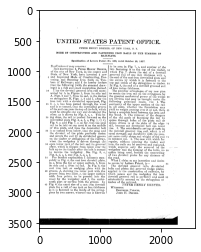

In [81]:
import matplotlib.pyplot as plt
plt.imshow(reconstruct, cmap = 'gray')

# SCRAP

In [38]:
# print(pytesseract.image_to_string(text_array, config='--psm 4'))

In [39]:
# print(pytesseract.image_to_string(text_array, config='--psm 12'))

In [40]:
print(OCR_img(text_array).replace(r"\d{2}", ""))

NameError: name 'text_array' is not defined

In [ ]:
print(pytesseract.image_to_osd(text_array), )

In [ ]:
# FIG_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/430/00000001.tif'
TEXT_PATH = '/Volumes/Non-Backup_Files/US-patents/random_sample_seeded/430/00000002.tif'
# fig_im = Image.open(FIG_PATH)
# text_im = Image.open(TEXT_PATH)
# fig_array = np.array(fig_im)
# text_array = np.array(text_im)